In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("science")
from gol import DormantLife

In [44]:
def DL_alive_cells(grid_size: int, runs: int, t_max: int,
                   alpha: float, base_seed: int = None) -> np.array:
    data = np.zeros((runs, t_max + 1))
    if base_seed is None:
        base_seed = np.random.randint(1)
    for i in range(runs):
        seed = base_seed + i
        rng = np.random.default_rng(seed)
        q = 0.37017384
        init_grid = rng.choice([0, 1], p=[1-q, q], size=[grid_size, grid_size])
        gol = DormantLife(init_grid)
        for j in range(t_max + 1):
            data[i, j] = gol.alive_count
            gol.step(alpha=alpha)
    return data

In [45]:
grid_size = 30
small_grid_size = 14
runs = 100
t_max = 5000
times = np.arange(t_max + 1)
base_seed = 100

In [46]:
data_1 = np.mean(DL_alive_cells(grid_size, runs, t_max, 1, base_seed), axis=0)
data_p75 = np.mean(DL_alive_cells(grid_size, runs, t_max, .75, base_seed), axis=0)
data_p5 = np.mean(DL_alive_cells(grid_size, runs, t_max, .5, base_seed), axis=0)
data_p35 = np.mean(DL_alive_cells(grid_size, runs, t_max, .35, base_seed), axis=0)
data_p25 = np.mean(DL_alive_cells(grid_size, runs, t_max, .25, base_seed), axis=0)
data_p1 = np.mean(DL_alive_cells(grid_size, runs, t_max, .1, base_seed), axis=0)
data_0 = np.mean(DL_alive_cells(grid_size, runs, t_max, 0, base_seed), axis=0)

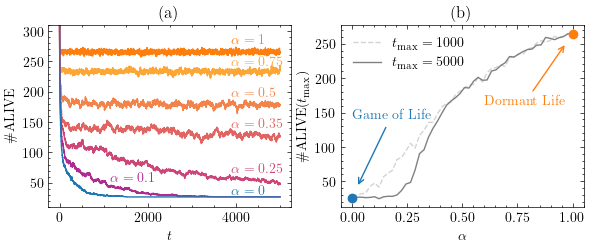

In [78]:
grid_size = 30
small_grid_size = 14
runs = 100
t_max = 5000
times = np.arange(t_max + 1)
base_seed = 100

alphas = [data_1,data_p75,data_p5,data_p35,data_p25,data_p1,data_0]
colors = ["tab:orange",
        *mpl.colormaps["plasma"](np.linspace(0.8, 0.4, 5)),
        "tab:blue"]
label_texts = [r"$\alpha = 1$", r"$\alpha = 0.75$", r"$\alpha = 0.5$",
                r"$\alpha = 0.35$", r"$\alpha = 0.25$", r"$\alpha = 0.1$",
                r"$\alpha = 0$"]
x_offsets = [0, 0, 0, 0, 0, -2750, 0]
y_offsets = [15, 2, 15, 15, 18, 25, 5]

def plot_time_series(ax, x, y, label_text, color, x_offset, y_offset):
    ax.plot(x, y, color=color)
    ax.text(x[-int(len(x)/4.5)]+x_offset, y[-1]+y_offset, label_text,
            color=color)

fig, (axl, axr) = plt.subplots(figsize=(6,3), ncols=2)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=None)
fig.tight_layout()
axl.set(title="(a)", box_aspect=3/4, ylim=(10,310))
axr.set(title="(b)", box_aspect=3/4)
axl.set(xlabel=r"$t$", ylabel=r"$\#\text{ALIVE}$")
for alpha, label_text, color, x_offset, y_offset in zip(alphas,
                                                        label_texts,
                                                        colors,
                                                        x_offsets,
                                                        y_offsets):
    data = alpha
    plot_time_series(axl, times, data, label_text, color, x_offset, y_offset)

alphas, N_alive_t_1000, N_alive_final = np.loadtxt("./data/phase_transition_2.dat")
axr.set(xlabel=r"$\alpha$", ylabel=r"$\#\text{ALIVE}(t_\text{max})$")
axr.plot(alphas, N_alive_t_1000, label=r"$t_\mathrm{max} = 1000$", color="lightgray", linestyle="--")
axr.plot(alphas, N_alive_final, label=r"$t_\mathrm{max} = 5000$", color="gray")
axr.annotate("Game of Life", (0, N_alive_final[0]), xytext=(0., 140),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:blue", "shrinkB":10},
            c="tab:blue")
axr.scatter(x=0, y=N_alive_final[0], c="tab:blue", zorder=10)
axr.annotate("Dormant Life", (1, N_alive_final[-1]), xytext=(.6, 160),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:orange", "shrinkB":10},
            c="tab:orange")
axr.scatter(x=1, y=N_alive_final[-1], c="tab:orange", zorder=10)
axr.legend()
fig.savefig("./img/phase_transition", dpi=500)

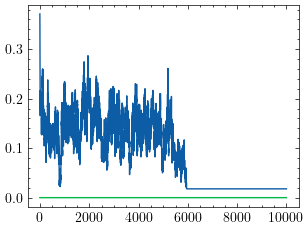

In [94]:
t_max = 10000
alpha = 0.25
N = 30
q = 0.37017384
init_grid = np.random.choice([0, 1], p=[1-q, q], size=[N, N])
gol = DormantLife(init_grid)
data = np.zeros(t_max)
while gol.t < t_max:
    data[gol.t] = gol.alive_count
    gol.step(alpha)
fig, ax = plt.subplots()
ax.plot(np.arange(t_max), data/N**2)
ax.plot(np.arange(t_max), [0]*t_max)
# ax.set(xlim=(8000,10000))

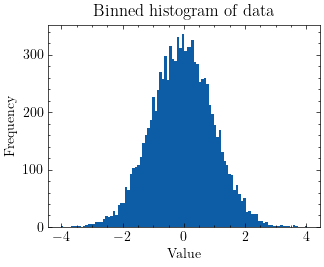

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
data = np.random.normal(size=10000)

# Compute the histogram with 10 bins
counts, edges = np.histogram(data, bins=100)

# Plot the histogram as a bar chart
plt.bar(edges[:-1], counts, width=np.diff(edges))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Binned histogram of data")
plt.show()


1758.561621838619
7293.273000601323
20283.575910931173
39804.15114672561


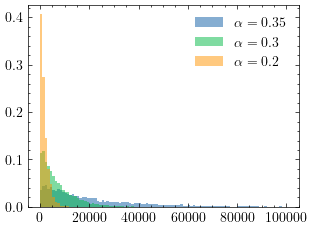

In [66]:
datap2 = np.loadtxt("./data/dormant-life/extinction-time/alpha-p2.dat")
datap3 = np.loadtxt("./data/dormant-life/extinction-time/alpha-p3.dat")
datap35 = np.loadtxt("./data/dormant-life/extinction-time/alpha-p35.dat")
datap4 = np.loadtxt("./data/dormant-life/extinction-time/alpha-p4.dat")
# Remove runs where no extinction time was found until t_max
datap2 = datap2[datap2>0]
datap3 = datap3[datap3>0]
datap35 = datap35[(datap35>0) & (datap35 <= 100000)]
datap4 = datap4[datap4>0]
print(np.mean(datap2))
print(np.mean(datap3))
print(np.mean(datap35))
print(np.mean(datap4))
# Compute the histogram
binwidth = 100_000 / 100 # 100 bins
bins = np.arange(0, 100_000 + binwidth, binwidth)
histp2 = np.histogram(datap2, bins=bins)
histp3 = np.histogram(datap3, bins=bins)
histp35 = np.histogram(datap35, bins=bins)
histp4 = np.histogram(datap4, bins=bins)
# Plot the histogram as a bar chart
fig, ax = plt.subplots()
# ax.set(xlim=(0, 10000))
# ax.bar(histp4[1][:-1], histp4[0]/len(datap4), width=np.diff(histp4[1]), align="edge", alpha=0.5, label=r"$\alpha = 0.4$")
ax.bar(histp35[1][:-1], histp35[0]/len(datap3), width=np.diff(histp35[1]), align="edge", alpha=0.5, label=r"$\alpha = 0.35$")
ax.bar(histp3[1][:-1], histp3[0]/len(datap3), width=np.diff(histp3[1]), align="edge", alpha=0.5, label=r"$\alpha = 0.3$")
ax.bar(histp2[1][:-1], histp2[0]/len(datap2), width=np.diff(histp2[1]), align="edge", alpha=0.5, label=r"$\alpha = 0.2$")
ax.legend()

In [4]:
from extinction_time import find_extinction_time
q = 0.37017384
grid_size = 30
init_grid = np.random.choice([0, 1], p=[1-q, q], size=[grid_size, grid_size])
dl = DormantLife(init_grid, alpha=0.4)
find_extinction_time(dl, 100_000)

83907